# II. Ensembles

В задачах нужно корректно реализовать функции, чтобы проходили тесты. 

## 1. Bootstrap.

### Алгоритм Bootstrap 
* Равномерно возьмем из выборки $N$ объектов **с возвращением**. То есть мы хотим сгенерировать псевдовыборку, в которой могут повторятся элементы из исходной выборки. 

* Обозначим новую выборку через $X_1$. Повторяя процедуру $B$ раз, сгенерируем $M$ подвыборок $X_1, \dots, X_B$. 

* Посчитаем статистику T от каждой выборки $(T(X_1), \ldots, T(X_n))$

* Найдем итоговую статистику $T(X) = \frac{1}{B}\sum^{B}_{i}T(X_i)$

На вход массив чисел $X$ и число бутстрепных выборок $B$. Необходимо реализовать свой бутстреп и найти матожидание и стандартную ошибку у бутстрепных выборок.


### TASK

In [1]:
import numpy as np
from scipy.stats import sem # ищет SE среднего

def get_stats(X: np.array, B:int)->tuple:
    N = len(X)
    indices = np.random.randint(0, N, (B, N))
    samples = X[indices]
    scores = list(map(np.mean, samples))
    scores_se = list(map(sem, samples))
    mean = np.mean(scores)
    SE = np.mean(scores_se)
    return mean, SE

### Open tests

In [2]:
X = np.array([37,43,38,36,17,40,40,45,41,84])
B = 100000

mean, se = get_stats(X, B)
print(mean, se)

assert np.abs(mean - 42.1) < 0.05
assert np.abs(se - 4.56) < 0.03




42.088018000000005 4.5712032125855595


# 2. Bagging

Необходимо реализовать свой небольшой беггинг на деревьях заданной грубины

* бустингом сделать несколько выборок $X_1, \ldots, X_B$
* обучить на этих выборках алгоритмы: $a_1(\cdot), \ldots, a_B(\cdot)$

Получить результат беггинга как:
$$a(x) = \frac{1}{B}\sum_{b=1}^{B}a_b(x)$$


# TASK

In [3]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR

def bagging(X_train, y_train, X_test, boot_count, depth):
    estimators = np.array([DTR(max_depth=depth) for _ in range(boot_count)])
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:YOUR CODE HERE・ﾟ
    pred = np.zeros((boot_count,len(X_test)))

    for i,clf in enumerate(estimators):

        indices = np.random.randint(0, len(X_train), len(X_train))
        clf.fit(X_train[indices],y_train[indices])
        pred[i,:] = clf.predict(X_test)    
    
    y_pred = np.mean(pred, axis = 0)
    return y_pred

In [4]:
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_equal, assert_almost_equal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


X_train = np.array([[0, 0], [1, 1], [5, 5], [8, 8], [10, 10]])
y_train = np.array([0, 1, 5, 8, 10])
X_test  = np.array([[4, 4], [6, 6]])
y_test  = np.array([4, 6])

B = 1000

y_pred = bagging(X_train, y_train, X_test, boot_count=B, depth=3)

assert_array_almost_equal(y_pred, np.array([4, 6]), decimal=0)


from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)



y_pred = bagging(X_train, y_train, X_test, boot_count=200, depth=10)

y_dt_pred = DecisionTreeRegressor().fit(X_train, y_train).predict(X_test)
y = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

print(mean_squared_error(y, y_test))
print(mean_squared_error(y_dt_pred, y_test))
print(mean_squared_error(y_pred, y_test))
assert mean_squared_error(y_pred, y_test) < 15

15.078526131578945
19.58730263157895
14.797131254409171


## 3. X-regression

Необходимо найти наилучшие параметры для XGBRegression, обучить модель и вернуть ее. Данные берутся из папки data.

Сам гридсерч или нативное исследование необходимо делать вне функции обработки, чтобы не получить TL.

### TASK

In [5]:
from xgboost import XGBRegressor
import xgboost
import pandas as pd
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

In [6]:
def search_params(X_train, y_train):
    
        parameters = { 'max_depth': [5, 10],
                            'eta': [0.01, 0.001], 
                            'subsample': [0.7],
                            'min_child_weight': [3],
                            'colsample_bytree': [0.7],
                            'colsample_bylevel': [0.7],      
                            'n_estimators': [250, 500, 1000]
                     }
        reg = XGBRegressor()
        model = GridSearchCV(reg, parameters, cv = 2, scoring = 'neg_mean_squared_error')
        model.fit(X_train, y_train)
        
        return model.best_score_, model.best_estimator_, model.best_params_, 

In [7]:
print(search_params(X_train, y_train))

(-11.586186851910416, XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None), {'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 1000, 'subsample': 0.7})


In [8]:
def xreg(X_train: np.array, y_train:np.array) -> XGBRegressor:
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
       
    model = XGBRegressor(n_estimators = 250, max_depth = 5, eta = 0.01,  
                         colsample_bylevel =  0.7, colsample_bytree = 0.7,
                         subsample =  0.5, min_child_weight = 1)
    model.fit(X_train, y_train)  
    
    return model

In [9]:
print(X_train.shape, X_test.shape)

(354, 13) (152, 13)


### OPEN TESTS

In [10]:
df = pd.read_csv('Financial Distress.csv')

X = df.drop('Financial Distress', axis=1)
y = df['Financial Distress']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

t1 = time.time()
xgb_model = xreg(X_train, y_train)
t2 = time.time()

#assert t2 - t1 < 10
print(t2-t1)
y_pred = xgb_model.predict(X_test)

print(MSE(y_pred, y_test))
assert type(xgb_model) == xgboost.sklearn.XGBRegressor
assert MSE(y_pred, y_test) < 3
print('Well Done')

0.46999311447143555
2.851985177648439
Well Done


## 4. CatFeatures

Обучите модель классификации катбуста на предложенных данных и верните обученную модель. 

Воспользуйтесь встроенной обработкой категориальных признаков. Не забудьте обработать Nan значения.

### TASK

In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import catboost
def catfeatures(df: pd.DataFrame):
    
    y = df['dep_delayed_15min']
    X = df.drop('dep_delayed_15min',axis=1)
    spis = ['Month', 'DayofMonth','DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']
    
    model = CatBoostClassifier(cat_features = spis)
    model.fit(X,y)
    
    return model

### TESTS

In [12]:
df = pd.read_csv('flight_delays_train.csv')
df_train = df[:7000]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [14]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Nan значений нет

In [15]:
%%time
                 
t1 = time.time()
model = catfeatures(df_train)
t2 = time.time()

                 
assert t2 - t1 < 10
assert type(model) == catboost.CatBoostClassifier

df_test = pd.read_csv('flight_catfeature_test.csv')
df_test = df_test.drop('Unnamed: 0', axis=1)
X_test = df_test.drop('dep_delayed_15min',axis=1)
y_test = df_test['dep_delayed_15min']

y_pred = model.predict(X_test)

y_pred = list(map(lambda x: 1 if x == 'Y' else 0, y_pred))
y_test = list(map(lambda x: 1 if x == 'Y' else 0, y_test))

Learning rate set to 0.023648
0:	learn: 0.6816060	total: 65.5ms	remaining: 1m 5s
1:	learn: 0.6709304	total: 69ms	remaining: 34.4s
2:	learn: 0.6606701	total: 75.2ms	remaining: 25s
3:	learn: 0.6503200	total: 80.9ms	remaining: 20.2s
4:	learn: 0.6410868	total: 84.7ms	remaining: 16.8s
5:	learn: 0.6334191	total: 87.9ms	remaining: 14.6s
6:	learn: 0.6245216	total: 95.5ms	remaining: 13.5s
7:	learn: 0.6166899	total: 107ms	remaining: 13.2s
8:	learn: 0.6088035	total: 118ms	remaining: 13s
9:	learn: 0.6011298	total: 132ms	remaining: 13s
10:	learn: 0.5941718	total: 138ms	remaining: 12.4s
11:	learn: 0.5887802	total: 141ms	remaining: 11.6s
12:	learn: 0.5827262	total: 144ms	remaining: 10.9s
13:	learn: 0.5766559	total: 152ms	remaining: 10.7s
14:	learn: 0.5720676	total: 155ms	remaining: 10.2s
15:	learn: 0.5665751	total: 161ms	remaining: 9.9s
16:	learn: 0.5616976	total: 173ms	remaining: 10s
17:	learn: 0.5570858	total: 180ms	remaining: 9.84s
18:	learn: 0.5534035	total: 184ms	remaining: 9.49s
19:	learn: 0.54

160:	learn: 0.4444724	total: 1.08s	remaining: 5.63s
161:	learn: 0.4442173	total: 1.09s	remaining: 5.64s
162:	learn: 0.4439950	total: 1.1s	remaining: 5.64s
163:	learn: 0.4438088	total: 1.1s	remaining: 5.64s
164:	learn: 0.4435763	total: 1.11s	remaining: 5.63s
165:	learn: 0.4434395	total: 1.12s	remaining: 5.63s
166:	learn: 0.4431758	total: 1.13s	remaining: 5.63s
167:	learn: 0.4431214	total: 1.13s	remaining: 5.61s
168:	learn: 0.4428638	total: 1.14s	remaining: 5.6s
169:	learn: 0.4426547	total: 1.15s	remaining: 5.6s
170:	learn: 0.4424591	total: 1.15s	remaining: 5.6s
171:	learn: 0.4423094	total: 1.16s	remaining: 5.59s
172:	learn: 0.4420436	total: 1.17s	remaining: 5.59s
173:	learn: 0.4419718	total: 1.17s	remaining: 5.57s
174:	learn: 0.4417937	total: 1.18s	remaining: 5.58s
175:	learn: 0.4415967	total: 1.19s	remaining: 5.57s
176:	learn: 0.4414222	total: 1.2s	remaining: 5.57s
177:	learn: 0.4413045	total: 1.2s	remaining: 5.56s
178:	learn: 0.4411958	total: 1.21s	remaining: 5.55s
179:	learn: 0.44102

327:	learn: 0.4226995	total: 2.19s	remaining: 4.49s
328:	learn: 0.4226635	total: 2.2s	remaining: 4.49s
329:	learn: 0.4224673	total: 2.21s	remaining: 4.48s
330:	learn: 0.4224553	total: 2.21s	remaining: 4.47s
331:	learn: 0.4223080	total: 2.22s	remaining: 4.46s
332:	learn: 0.4221454	total: 2.22s	remaining: 4.45s
333:	learn: 0.4219723	total: 2.23s	remaining: 4.44s
334:	learn: 0.4218333	total: 2.24s	remaining: 4.44s
335:	learn: 0.4218008	total: 2.24s	remaining: 4.43s
336:	learn: 0.4217347	total: 2.25s	remaining: 4.42s
337:	learn: 0.4216708	total: 2.25s	remaining: 4.41s
338:	learn: 0.4216152	total: 2.26s	remaining: 4.41s
339:	learn: 0.4214147	total: 2.27s	remaining: 4.4s
340:	learn: 0.4213401	total: 2.27s	remaining: 4.39s
341:	learn: 0.4213172	total: 2.28s	remaining: 4.38s
342:	learn: 0.4211547	total: 2.29s	remaining: 4.39s
343:	learn: 0.4209824	total: 2.3s	remaining: 4.38s
344:	learn: 0.4209357	total: 2.3s	remaining: 4.37s
345:	learn: 0.4208572	total: 2.31s	remaining: 4.37s
346:	learn: 0.42

499:	learn: 0.4029253	total: 3.4s	remaining: 3.4s
500:	learn: 0.4027529	total: 3.4s	remaining: 3.39s
501:	learn: 0.4026256	total: 3.41s	remaining: 3.38s
502:	learn: 0.4025103	total: 3.42s	remaining: 3.38s
503:	learn: 0.4023240	total: 3.42s	remaining: 3.37s
504:	learn: 0.4022764	total: 3.43s	remaining: 3.36s
505:	learn: 0.4022101	total: 3.43s	remaining: 3.35s
506:	learn: 0.4021058	total: 3.44s	remaining: 3.35s
507:	learn: 0.4019894	total: 3.45s	remaining: 3.34s
508:	learn: 0.4018852	total: 3.45s	remaining: 3.33s
509:	learn: 0.4018019	total: 3.46s	remaining: 3.33s
510:	learn: 0.4016760	total: 3.47s	remaining: 3.32s
511:	learn: 0.4015657	total: 3.48s	remaining: 3.31s
512:	learn: 0.4014796	total: 3.48s	remaining: 3.31s
513:	learn: 0.4014267	total: 3.49s	remaining: 3.3s
514:	learn: 0.4013193	total: 3.49s	remaining: 3.29s
515:	learn: 0.4012761	total: 3.5s	remaining: 3.28s
516:	learn: 0.4011696	total: 3.51s	remaining: 3.28s
517:	learn: 0.4011019	total: 3.52s	remaining: 3.27s
518:	learn: 0.401

674:	learn: 0.3862807	total: 4.62s	remaining: 2.22s
675:	learn: 0.3862358	total: 4.63s	remaining: 2.22s
676:	learn: 0.3861320	total: 4.63s	remaining: 2.21s
677:	learn: 0.3860490	total: 4.64s	remaining: 2.2s
678:	learn: 0.3858571	total: 4.65s	remaining: 2.2s
679:	learn: 0.3858214	total: 4.65s	remaining: 2.19s
680:	learn: 0.3857182	total: 4.66s	remaining: 2.18s
681:	learn: 0.3856288	total: 4.67s	remaining: 2.18s
682:	learn: 0.3855876	total: 4.67s	remaining: 2.17s
683:	learn: 0.3855573	total: 4.68s	remaining: 2.16s
684:	learn: 0.3855353	total: 4.68s	remaining: 2.15s
685:	learn: 0.3855037	total: 4.69s	remaining: 2.15s
686:	learn: 0.3853957	total: 4.7s	remaining: 2.14s
687:	learn: 0.3852468	total: 4.71s	remaining: 2.14s
688:	learn: 0.3851463	total: 4.72s	remaining: 2.13s
689:	learn: 0.3850550	total: 4.72s	remaining: 2.12s
690:	learn: 0.3849462	total: 4.73s	remaining: 2.12s
691:	learn: 0.3849021	total: 4.74s	remaining: 2.11s
692:	learn: 0.3848301	total: 4.74s	remaining: 2.1s
693:	learn: 0.38

833:	learn: 0.3718276	total: 5.82s	remaining: 1.16s
834:	learn: 0.3717683	total: 5.82s	remaining: 1.15s
835:	learn: 0.3716417	total: 5.83s	remaining: 1.14s
836:	learn: 0.3715567	total: 5.84s	remaining: 1.14s
837:	learn: 0.3714241	total: 5.84s	remaining: 1.13s
838:	learn: 0.3713500	total: 5.85s	remaining: 1.12s
839:	learn: 0.3712719	total: 5.86s	remaining: 1.11s
840:	learn: 0.3712254	total: 5.86s	remaining: 1.11s
841:	learn: 0.3711704	total: 5.87s	remaining: 1.1s
842:	learn: 0.3709560	total: 5.88s	remaining: 1.09s
843:	learn: 0.3709243	total: 5.88s	remaining: 1.09s
844:	learn: 0.3709075	total: 5.89s	remaining: 1.08s
845:	learn: 0.3708583	total: 5.9s	remaining: 1.07s
846:	learn: 0.3707741	total: 5.9s	remaining: 1.07s
847:	learn: 0.3707029	total: 5.91s	remaining: 1.06s
848:	learn: 0.3706094	total: 5.92s	remaining: 1.05s
849:	learn: 0.3704705	total: 5.93s	remaining: 1.05s
850:	learn: 0.3704003	total: 5.94s	remaining: 1.04s
851:	learn: 0.3702669	total: 5.95s	remaining: 1.03s
852:	learn: 0.3

998:	learn: 0.3580211	total: 7.02s	remaining: 7.03ms
999:	learn: 0.3579741	total: 7.03s	remaining: 0us
CPU times: user 32.8 s, sys: 4 s, total: 36.8 s
Wall time: 7.4 s


In [16]:
assert accuracy_score(y_test, y_pred) > 0.80 
print('Well Done')

Well Done


## 5. Производные для регрессии

Пусть мы хотим бустить регрессию со стандартной функцией потерь $MSE$:

$$\mathcal{L}(a, x,y) = (a(x_i) - y_i)^2$$

Необходимо найти через взятие производных:

1. Константный вектор $[f_0]_{i=1}^{N}$
$$f_0(x) = \arg\min_{ c\in \mathbb{R}} \sum_{i=1}^n \mathcal{L}(c, y_i)$$ 

2. Градиенты функции потерь
$$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$$

3. Коэффициенты при композиции 
$$\alpha_{t + 1} = \arg\min_\alpha \sum_{i=1}^N \mathcal{L}(f_{t}(x_i) + \alpha b_{t+1}(x_i), y_i)$$

### TASK

In [17]:
def init(y_i: np.array) -> float:
    f_0 = np.mean(y_i)
    return f_0

def grad(a: np.array, y: np.array) -> np.array:
    g = -2*(a-y)
    return g

def alpha(f :np.array, b: np.array, y: np.array) -> float:
    alpha = -np.sum((y-f)*b)/np.sum(b**2)
    return alpha

In [18]:
b = np.array([0, 2, 4])
b**2

array([ 0,  4, 16])

### TESTS

In [19]:
y = np.array([1, 2, 3])
f = np.array([2, 2, 2])
b = np.array([0, 2, 4])

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 2.0)   < 1e-9
assert_array_almost_equal(g, np.array([-2, 0, 2]))
assert np.abs(al - (-0.2)) < 1e-9
######################################################
y = np.arange(20)
f = np.ones(20) * 10
b = np.arange(20) - 1

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 9.5)   < 1e-2
assert_array_almost_equal(g, np.arange(-20,20, 2))
assert np.abs(al - (-0.2748)) < 1e-2
print('Well Done!')

Well Done!


## 6. GradientBoosting

Реализуйте градиентный бустинг на решающих деревьях для регрессии с логгированием.Верните модель, которая будет хранить в себе `n_estimatos` обученных деревьев и коэффициенты, чтобы с их помощью потом найти результат предсказания.

Также необходимо реализовать логгирование в течение обучения.
* `self.estimators` - лист c деревьями
* `self.alpha` - лист с коэффициентами альфа
* `self.f_list` - лист со значениями комбинаций алгоритма $f_T(x_i) = f_0(x_i) + \sum_{t=1}^{T}\alpha_tb_t(x_i)$
* `self.g_list` - лист с векторами градиентов на каждой итерации $g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$
* `self.b_list` - лист со значениями базового обучаемого дерева на тренировачной выборке на каждой итерации 

Примечания:
* Обрывать алгоритм не нужно, необходимо обучить все деревья.
* Начальный константный вектор из $f_0$ логгировать не нужно, однако не забудьте его добавить в `predict` c нужным количеством объектов!

### TASK

In [20]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error
import math
from scipy import optimize

class MyGradBoost():
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators_ = np.array([DTR(max_depth=self.max_depth) for _ in range(n_estimators)])
        self.alpha = []
        self.f_list = []
        self.b_list = []
        self.g_list = []
        
    def fit(self, X_train: np.array, y_train: np.array): 
        f_0 = np.array([np.mean(y_train)]*len(y_train))   
        self.f_list.append(f_0)
        
        for i in range(self.n_estimators):
            
            a = self.f_list[i].copy()
            
            g = -2*(a-y_train)
            self.g_list.append(g) 
            
            b_est = self.estimators_[i].fit(X_train, g)
            b = np.array(b_est.predict(X_train))
            self.b_list.append(b)
            
            alpha = np.sum((y_train-a)*b)/np.sum(b**2)
            self.alpha.append(alpha)
            
            a += alpha*b 
            self.f_list.append(a)

            
        
        return self
        
    def predict(self, X_test) -> np.array:
        
        y_pred = np.array([self.f_list[0][0]]*(X_test.shape[0]))
        
        for k in range(self.n_estimators):
            y_pred += np.array(self.alpha[k])*np.array(self.estimators_[k].predict(X_test)) 
        
        return y_pred
    
    def score(self, X_test, y_test)-> np.array:
        return mean_squared_error(self.predict(X_test), y_test)

### TESTS

In [21]:
n_estimators = 2
max_depth=3
X_train = np.array([[0], [1], [2], [3], [4]])
y_train = np.array([0, 2, 4, 2, 0])
X_test  = np.array([[1.2], [2.3]])
y_test  = np.array([2.2, 3.7])

model = MyGradBoost(n_estimators=n_estimators, max_depth=max_depth).fit(X_train, y_train)
assert model.score(X_test, y_test) < 0.2
######################################################
n_train, n_test, noise = 150, 1000, 0.1
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)


model = MyGradBoost().fit(X_train, y_train)
assert model.score(X_test, y_test) < 0.025


model = MyGradBoost(n_estimators=100, 
                    max_depth=1).fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.017
print('Well Done')

Well Done


# Самопроверка

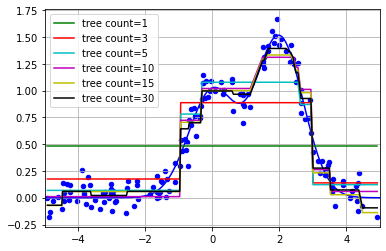

In [22]:
import matplotlib.pyplot as plt
def predict_and_plot(model, X_test, y_test, title):
    y_predict = model.predict(X_test)

    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, y_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("{} Loss: {:2f}".format(title, model.score(X_test, y_test)))
    plt.grid()



model = MyGradBoost(n_estimators=30, 
                    max_depth=1).fit(X_train, y_train)

ind =  [1,3,5,10,15,30]

# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
n_est = [1,3,5,10,15,30]
f = np.array(model.f_list)
for i, n in enumerate(n_est):
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    plt.plot(X_train, f[n-1], color=colors[i], label="tree count={}".format(n))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()